In [4]:
#python code to downloading abstracts

import urllib2
from urllib2 import HTTPError
import Bio
from Bio import Entrez
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
import nltk
from gensim.models import CoherenceModel,LdaModel,LsiModel,HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import dictionary
from gensim import corpora
#import pyLDAvis.gensim
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
import os,re,operator,warnings
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora, models

In [2]:
# search for abstracts from pubmed with key words "particulate matter" in 2016
Entrez.email = "history.user@example.com"
search_results = Entrez.read(Entrez.esearch(db="pubmed",
                                            term="particulate matter",
                                            mindate="2016", maxdate="2016", datetype="pdat",
                                            usehistory="y"))
count = int(search_results["Count"])
print("Found %i results" % count)

Found 3721 results


In [3]:
# download abstracts

batch_size = 10
out_handle = open("pm.txt", "w")
for start in range(0,count,batch_size):
    end = min(count, start+batch_size)
    print("Going to download record %i to %i" % (start+1, end))
    attempt = 1
    while attempt <= 3:
        try:
            fetch_handle = Entrez.efetch(db="pubmed",rettype="medline",
                                         retmode="text",retstart=start,
                                         retmax=batch_size,
                                         webenv=search_results["WebEnv"],
                                         query_key=search_results["QueryKey"])
            attempt=4
        except HTTPError as err:
            if 500 <= err.code <= 599:
                print("Received error from server %s" % err)
                print("Attempt %i of 3" % attempt)
                attempt += 1
                time.sleep(15)
            else:
                raise
    data = fetch_handle.read()
    fetch_handle.close()
    out_handle.write(data)
out_handle.close()

Going to download record 1 to 10
Going to download record 11 to 20
Going to download record 21 to 30
Going to download record 31 to 40
Going to download record 41 to 50
Going to download record 51 to 60
Going to download record 61 to 70
Going to download record 71 to 80
Going to download record 81 to 90
Going to download record 91 to 100
Going to download record 101 to 110
Going to download record 111 to 120
Going to download record 121 to 130
Going to download record 131 to 140
Going to download record 141 to 150
Going to download record 151 to 160
Going to download record 161 to 170
Going to download record 171 to 180
Going to download record 181 to 190
Going to download record 191 to 200
Going to download record 201 to 210
Going to download record 211 to 220
Going to download record 221 to 230
Going to download record 231 to 240
Going to download record 241 to 250
Going to download record 251 to 260
Going to download record 261 to 270
Going to download record 271 to 280
Going to dow

Going to download record 2221 to 2230
Going to download record 2231 to 2240
Going to download record 2241 to 2250
Going to download record 2251 to 2260
Going to download record 2261 to 2270
Going to download record 2271 to 2280
Going to download record 2281 to 2290
Going to download record 2291 to 2300
Going to download record 2301 to 2310
Going to download record 2311 to 2320
Going to download record 2321 to 2330
Going to download record 2331 to 2340
Going to download record 2341 to 2350
Going to download record 2351 to 2360
Going to download record 2361 to 2370
Going to download record 2371 to 2380
Going to download record 2381 to 2390
Going to download record 2391 to 2400
Going to download record 2401 to 2410
Going to download record 2411 to 2420
Going to download record 2421 to 2430
Going to download record 2431 to 2440
Going to download record 2441 to 2450
Going to download record 2451 to 2460
Going to download record 2461 to 2470
Going to download record 2471 to 2480
Going to dow

In [4]:
# this function retrieves only abstracts

def extract_abstracts(in_file,out_file):
    again=False
    buffer=[]
    for line in in_file:
        if line.startswith("AB") or again==True and not (line.startswith('FAU') or line.startswith('CI')):
            buffer.append(line)
            again=True
            continue
        elif (line.startswith("FAU") or line.startswith("CI")) and again==True:
            out_file.write("".join(buffer))
            buffer=[]
            again=False
        else:
             continue

In [5]:
# read the abstract files with metadata

file_in = open("pm.txt")
file_out = open("abstract_pm.txt","w")
extract_abstracts(file_in,file_out)   ## extract the abstracts from the file

## Topic modeling

In [1]:
# import all libraries
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
from nltk.tokenize import RegexpTokenizer
import gensim
from gensim import corpora, models

In [2]:
# set the stop word list, punctuation list and lemma 

stop = set(stopwords.words('english'))
#add custom words
stop.update(('and','I','A','And','So','arnt','This','When','It','many','Many'))

exclude = set(string.punctuation)
# initialize lemmatizer
lemma = WordNetLemmatizer()
# initialize  stemmer
porter_stemmer = PorterStemmer()
# initialize tokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [6]:
abs_file = open("abstract_pm.txt").read()
abs_file_in = abs_file.split('AB')
texts = []
# loop through document list
for i in abs_file_in:

# clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)
    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stop]
    # stem tokens
    stemmed_tokens = [porter_stemmer.stem(i) for i in stopped_tokens]
    
    punc_free = [ch for ch in stemmed_tokens if ch not in exclude]
    
    number_free = [re.sub('[0-9]+', '', ch) for ch in punc_free]
    
    str_list = [x for x in number_free if x != '']
    # add tokens to list
    texts.append(str_list)

# Using Gensim library 


# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
dictionary.save('dictionary.dict')
print(dictionary)
 
# convert tokenized documents into a document-term matrix
doc_term_matrix = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

Dictionary(17226 unique tokens: [u'hcho', u'ocimum', u'xylen', u'nanospher', u'orthogon']...)


In [7]:
print (len(doc_term_matrix))
print (doc_term_matrix[3])

3657
[(10, 1), (16, 2), (24, 3), (36, 1), (51, 1), (55, 1), (64, 1), (70, 4), (74, 1), (97, 1), (102, 2), (103, 1), (107, 1), (109, 1), (111, 1), (130, 2), (137, 1), (143, 1), (155, 1), (203, 2), (204, 1), (205, 1), (206, 1), (207, 2), (208, 1), (209, 1), (210, 1), (211, 1), (212, 1), (213, 1), (214, 1), (215, 3), (216, 2), (217, 1), (218, 1), (219, 1), (220, 1), (221, 2), (222, 1), (223, 1), (224, 1), (225, 1), (226, 1), (227, 2), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 1), (238, 1), (239, 1), (240, 1), (241, 2), (242, 1), (243, 1), (244, 2), (245, 1), (246, 1), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 1), (255, 2), (256, 1), (257, 1)]


In [8]:
# Running LDA Model

#Next step is to create an object for LDA model and train it on Document-Term matrix.

#The training also requires few parameters as input which are explained in the above section.
#The gensim module allows both LDA model estimation from a training corpus and 
# inference of topic distribution on new, unseen documents.

In [9]:
from time import time
start = time()
# Creating the object for LDA model using gensim library
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix, num_topics=4, id2word = dictionary, passes=50)

In [10]:
# print word distribution per topic
for i in ldamodel.print_topics(): 
    for j in i: print (j)

0
0.039*"pm" + 0.021*"pollut" + 0.020*"air" + 0.017*"associ" + 0.015*"exposur" + 0.011*"studi" + 0.010*"model" + 0.010*"concentr" + 0.009*"increas" + 0.009*"health"
1
0.017*"cell" + 0.012*"exposur" + 0.011*"pm" + 0.010*"induc" + 0.009*"group" + 0.009*"effect" + 0.008*"express" + 0.008*"increas" + 0.008*"smoke" + 0.008*"lung"
2
0.012*"concentr" + 0.009*"particl" + 0.008*"dust" + 0.008*"sampl" + 0.008*"use" + 0.007*"sourc" + 0.005*"emiss" + 0.005*"result" + 0.005*"particul" + 0.005*"studi"
3
0.028*"smoke" + 0.023*"exposur" + 0.012*"studi" + 0.010*"use" + 0.009*"children" + 0.008*"tobacco" + 0.008*"associ" + 0.007*"risk" + 0.007*"health" + 0.006*"level"


In [11]:
#print topic distribution per document
#bow1 = dictionary.doc2bow(texts[0])
#bow2 = dictionary.doc2bow(texts[1])
#bow3 = dictionary.doc2bow(texts[2])
#bow4 = dictionary.doc2bow(texts[3])
#bow5 = dictionary.doc2bow(texts[4])

print(ldamodel.get_document_topics(dictionary.doc2bow(texts[0])))
print(ldamodel.get_document_topics(dictionary.doc2bow(texts[1])))
print(ldamodel.get_document_topics(dictionary.doc2bow(texts[2])))
print(ldamodel.get_document_topics(dictionary.doc2bow(texts[3])))
print(ldamodel.get_document_topics(dictionary.doc2bow(texts[4])))

[(0, 0.25), (1, 0.25), (2, 0.25), (3, 0.25)]
[(0, 0.94380737636667222), (2, 0.053355951782019462)]
[(2, 0.99580541446802462)]
[(0, 0.73195042155515477), (3, 0.26246180169577754)]
[(0, 0.37680822295944211), (1, 0.26175368860499304), (2, 0.35987238480718348)]


In [12]:
L=len(ldamodel.get_document_topics(dictionary.doc2bow(texts[0])))

In [13]:
L

4

In [14]:
# The code below gives the label of documents based on probability distribution of topics

In [15]:
# document_topic matrix
docTopicProbMat = ldamodel[doc_term_matrix]

# create a classification label
label =[]
print(len(label))
for i in range  (0,len(docTopicProbMat)):
# create a classification label
    L = ldamodel.get_document_topics(dictionary.doc2bow(texts[i]))
    S = sorted(L, key = lambda score: score[1], reverse = True)
    label.append(S[0][0])
print(label)

0
[0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 3, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 2, 2, 2, 0, 3, 1, 2, 2, 1, 0, 1, 3, 1, 1, 1, 3, 3, 0, 3, 2, 1, 2, 0, 2, 1, 2, 0, 3, 0, 3, 3, 2, 2, 2, 0, 2, 3, 3, 0, 2, 2, 2, 1, 2, 0, 2, 0, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 0, 2, 2, 3, 0, 2, 2, 1, 3, 2, 1, 0, 2, 1, 1, 2, 3, 2, 1, 2, 2, 3, 3, 3, 3, 2, 2, 0, 1, 3, 2, 0, 1, 2, 2, 2, 0, 0, 1, 2, 2, 1, 1, 2, 2, 1, 0, 3, 2, 0, 2, 2, 1, 0, 2, 0, 3, 2, 3, 2, 1, 1, 3, 1, 2, 2, 2, 0, 1, 3, 3, 3, 3, 2, 3, 2, 3, 0, 2, 3, 0, 1, 3, 2, 0, 0, 2, 2, 2, 1, 1, 1, 0, 3, 0, 0, 3, 3, 1, 3, 1, 2, 0, 2, 2, 0, 3, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 1, 3, 2, 3, 0, 2, 0, 3, 3, 0, 2, 3, 2, 1, 2, 1, 0, 2, 2, 1, 0, 3, 0, 1, 3, 3, 1, 0, 0, 1, 1, 0, 2, 2, 0, 1, 0, 0, 2, 1, 2, 3, 1, 2, 2, 0, 0, 3, 2, 2, 2, 1, 3, 0, 0, 2, 1, 2, 2, 0, 1, 2, 3, 2, 2, 1, 0, 0, 0, 2, 2, 0, 2, 2, 2, 0

In [16]:
from pandas import Series, DataFrame

sentence_label = DataFrame({'Sentence': abs_file_in,
                        'Label': label,})

In [17]:
sentence_label

Label                                           Sentence
0         0                                                   
1         0    - High concentrations of particulate matter ...
2         2    - Atmospheric aerosols are the dominant sour...
3         0    - Research examining racial/ethnic dispariti...
4         0    - Filter-based toxicology studies are conduc...
5         0    - Exposure assessment for elemental componen...
6         0    - BACKGROUND: Ambient (outdoor) air pollutio...
7         0    - BACKGROUND: Ambient air pollution contains...
8         2    - Bivalves process large volumes of water, l...
9         2    - Electronic cigarettes (ECIGs) electrically...
10        0    - INTRODUCTION: Previous studies have examin...
11        3   panel study of N= 76\n      postinfarction pa...
12        0  ETES study of con- trolled exposure to ultrafi...
13        0   study, similarly, IQR increases in UFP concen...
14        0  ETES study (lagged 1 hour: -13.22%; 95% CI, -2...
15        0   study, IQR increases in PM2.5\n      concentr...
16        0   study, similarly, increases in PM2.5 concen- ...
17        0    - Air pollution is a severe threat to public...
18        2    - The national Air Pollution Prevention and ...
19        2    - To investigate the influence of haze on th...
20        0    - In 2013, China issued "Air Pollution Preve...
21        2    - Mineral particles or particulate matters (...
22        0    - Wildfire can impose a direct impact on hum...
23        1    - OBJECTIVES: To explore whether the inhibit...
24        0    - This chapter gives a comprehensive overvie...
25        2    - A severe dust event occurred from April 23...
26        2    - The reaction of HCHO with Beijing winter's...
27        2    - Trajectory clustering, potential source co...
28        2    - Long-term and synchronous monitoring of PM...
29        2    - Advances in analytical techniques and inst...
...     ...                                                ...
3627      3    - OBJECTIVES: Secondhand tobacco smoke (SHS)...
3628      3    - INTRODUCTION: Parental smoking has been id...
3629      0    - BACKGROUND: Long-term exposure to fine par...
3630      1    - CONTEXT: Tobacco smoking generates a treme...
3631      0    - Understanding how weather impacts health i...
3632      3    - To assess the impact of sanitation of a li...
3633      3    - The aim of this study was to characterize ...
3634      2    - Cadmium (Cd) contaminated in rice grains i...
3635      3    - PURPOSE: In some countries with high smoki...
3636      2    - OBJECTIVES: The American Conference of Gov...
3637      2    - We measured particulate matter (PM), acrol...
3638      1    - We aimed to elucidate the molecular change...
3639      2    - This study presents a method to retrieve v...
3640      0    - Exposure models are needed to evaluate the...
3641      3    - The potential for para-occupational, domes...
3642      0    - A growing literature explores intra-urban ...
3643      1    - Chronic cardiovascular disease is associat...
3644      2    - We monitored black carbon (BC) concentrati...
3645      3    - INTRODUCTION: Despite the large amount tha...
3646      1    - The aim of this study was to explore the i...
3647      2    - INTRODUCTION: Electronic cigarettes (ECIGs...
3648      2    - The main purpose of this study was to moni...
3649      1    - Airborne exposure to particulate matter wi...
3650      0    - Fine particulate matter <2.5 mum (PM2.5) h...
3651      2    - Recently, fly ash deposits have been revea...
3652      3    - INTRODUCTION: Tobacco control prevention e...
3653      3    - OBJECTIVE: Lead (Pb), mercury (Hg) and cad...
3654      3    - CONTEXT: The Tobacco Control Network (TCN)...
3655      3    - OBJECTIVES: To examine the association bet...
3656      1    - OBJECTIVE: To investigate the contribution...

[3657 rows x 2 columns]

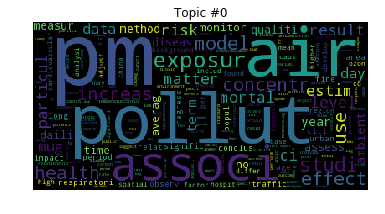

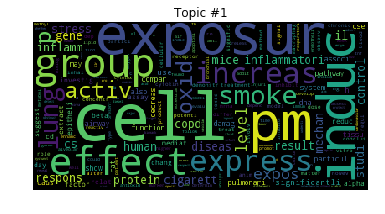

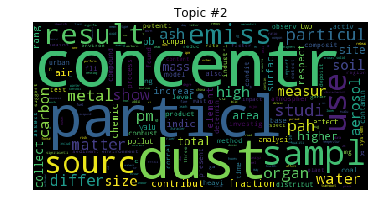

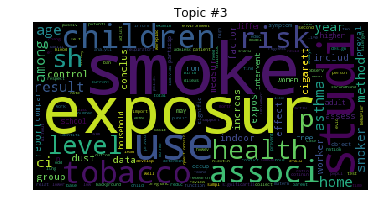

In [18]:
# print wordcloud
# install wordcloud in Anaconda plot
# conda install -c https://conda.anaconda.org/conda-forge wordcloud
!pip install wordcloud
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS
for t in range(ldamodel.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(ldamodel.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [19]:
ldamodel.show_topics(num_topics=4, num_words=4)

[(0, u'0.039*"pm" + 0.021*"pollut" + 0.020*"air" + 0.017*"associ"'),
 (1, u'0.017*"cell" + 0.012*"exposur" + 0.011*"pm" + 0.010*"induc"'),
 (2, u'0.012*"concentr" + 0.009*"particl" + 0.008*"dust" + 0.008*"sampl"'),
 (3, u'0.028*"smoke" + 0.023*"exposur" + 0.012*"studi" + 0.010*"use"')]

In [20]:
# we can print words per topic
print(ldamodel.print_topics(num_topics=4, num_words=4))

[(0, u'0.039*"pm" + 0.021*"pollut" + 0.020*"air" + 0.017*"associ"'), (1, u'0.017*"cell" + 0.012*"exposur" + 0.011*"pm" + 0.010*"induc"'), (2, u'0.012*"concentr" + 0.009*"particl" + 0.008*"dust" + 0.008*"sampl"'), (3, u'0.028*"smoke" + 0.023*"exposur" + 0.012*"studi" + 0.010*"use"')]


In [21]:
for i in ldamodel.print_topics(): 
    for j in i: print (j)

0
0.039*"pm" + 0.021*"pollut" + 0.020*"air" + 0.017*"associ" + 0.015*"exposur" + 0.011*"studi" + 0.010*"model" + 0.010*"concentr" + 0.009*"increas" + 0.009*"health"
1
0.017*"cell" + 0.012*"exposur" + 0.011*"pm" + 0.010*"induc" + 0.009*"group" + 0.009*"effect" + 0.008*"express" + 0.008*"increas" + 0.008*"smoke" + 0.008*"lung"
2
0.012*"concentr" + 0.009*"particl" + 0.008*"dust" + 0.008*"sampl" + 0.008*"use" + 0.007*"sourc" + 0.005*"emiss" + 0.005*"result" + 0.005*"particul" + 0.005*"studi"
3
0.028*"smoke" + 0.023*"exposur" + 0.012*"studi" + 0.010*"use" + 0.009*"children" + 0.008*"tobacco" + 0.008*"associ" + 0.007*"risk" + 0.007*"health" + 0.006*"level"


In [22]:
# We can save model for future use
ldamodel.save('topic.model')

In [23]:
#load saved model
from gensim.models import LdaModel
loading = LdaModel.load('topic.model')

In [24]:
print(loading.print_topics(num_topics=2, num_words=4))

[(0, u'0.039*"pm" + 0.021*"pollut" + 0.020*"air" + 0.017*"associ"'), (3, u'0.028*"smoke" + 0.023*"exposur" + 0.012*"studi" + 0.010*"use"')]


In [25]:
# For plotting we need  model, corpus and dictionary

# install pyLDAvis 
! pip install pyLDAvis

In [26]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [27]:
d = gensim.corpora.Dictionary.load('dictionary.dict')
c = gensim.corpora.MmCorpus('corpus.mm')
lda = gensim.models.LdaModel.load('topic.model')

In [28]:
data = pyLDAvis.gensim.prepare(lda, c, d)
data

/Users/zhemeng/anaconda/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      38.860116        1       1 -0.066625 -0.171136
0      25.876787        1       2 -0.101628  0.030673
3      19.007396        1       3 -0.050931  0.144649
1      16.255701        1       4  0.219184 -0.004186, topic_info=      Category         Freq          Term        Total  loglift  logprob
term                                                                    
11240  Default  7415.000000            pm  7415.000000  30.0000  30.0000
4339   Default  3614.000000         smoke  3614.000000  29.0000  29.0000
4121   Default  3597.000000        pollut  3597.000000  28.0000  28.0000
11026  Default  5589.000000       exposur  5589.000000  27.0000  27.0000
7500   Default  1519.000000          cell  1519.000000  26.0000  26.0000
4923   Default  3628.000000           air  3628.000000  25.0000  25.0000
10831  Default  3610.000000        associ  3610.000000  24.0000  24.0000
8025   Default   948.000000         induc   948.000000  23.0000  23.0000
10582  Default  1048.000000      children  1048.000000  22.0000  22.0000
11144  Default   752.000000       express   752.000000  21.0000  21.0000
3797   Default  1569.000000            ci  1569.000000  20.0000  20.0000
16335  Default   926.000000       tobacco   926.000000  19.0000  19.0000
9780   Default  1398.000000         group  1398.000000  18.0000  18.0000
4093   Default  1063.000000          lung  1063.000000  17.0000  17.0000
15362  Default  2236.000000        health  2236.000000  16.0000  16.0000
12057  Default   844.000000        mortal   844.000000  15.0000  15.0000
1281   Default   616.000000            sh   616.000000  14.0000  14.0000
2344   Default   947.000000      cigarett   947.000000  13.0000  13.0000
9169   Default   492.000000            il   492.000000  12.0000  12.0000
13411  Default   998.000000         expos   998.000000  11.0000  11.0000
1974   Default   485.000000          mice   485.000000  10.0000  10.0000
5060   Default   892.000000          oxid   892.000000   9.0000   9.0000
8241   Default   558.000000          home   558.000000   8.0000   8.0000
8255   Default  1304.000000         estim  1304.000000   7.0000   7.0000
10239  Default   480.000000       protein   480.000000   6.0000   6.0000
10261  Default   903.000000           pah   903.000000   5.0000   5.0000
11583  Default  1057.000000         metal  1057.000000   4.0000   4.0000
3929   Default  2235.000000          dust  2235.000000   3.0000   3.0000
3112   Default  1015.000000           age  1015.000000   2.0000   2.0000
8836   Default   437.000000  inflammatori   437.000000   1.0000   1.0000
...        ...          ...           ...          ...      ...      ...
3817    Topic4   380.202508            cs   402.406155   1.7600  -5.4502
1266    Topic4   408.868398        stress   438.516974   1.7467  -5.3775
2454    Topic4   275.125962        airway   299.435867   1.7321  -5.7736
401     Topic4   198.910467         vitro   210.896485   1.7582  -6.0980
5673    Topic4   185.547928             a   196.142127   1.7612  -6.1676
7824    Topic4   246.069261         tissu   275.583929   1.7034  -5.8853
4093    Topic4   724.231681          lung  1063.315619   1.4327  -4.8058
15848   Topic4   249.241142         damag   291.865833   1.6589  -5.8725
479     Topic4   385.200632          copd   505.554586   1.5448  -5.4371
10075   Topic4   228.279072        mediat   263.022472   1.6751  -5.9603
6841    Topic4   239.104779         alpha   279.349432   1.6612  -5.9140
9780    Topic4   796.699885         group  1398.089622   1.2543  -4.7104
5060    Topic4   562.913805          oxid   892.137646   1.3562  -5.0577
594     Topic4   501.030056       respons   810.547455   1.3357  -5.1742
13411   Topic4   550.112920         expos   998.879199   1.2202  -5.0807
11683   Topic4   214.608365         assay   245.898268   1.6806  -6.0221
2344    Topic4   494.287305      cigarett   947.409440  

## Clustering

In [76]:
import Bio
from Bio import Entrez
import time

import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import gensim
import nltk
from gensim.models import CoherenceModel,LdaModel,LsiModel,HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import dictionary
from gensim import corpora, models
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
import string
import os,re,operator,warnings

In [77]:
!pip install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
import pylab as pl
from sklearn.decomposition import PCA,TruncatedSVD

Requirement already up-to-date: scikit-learn in /Users/zhemeng/anaconda/lib/python2.7/site-packages


In [78]:
%cd /Users/zhemeng/Documents/BSTT 594 (2017 F)/Final project

/Users/zhemeng/Documents/BSTT 594 (2017 F)/Final project


In [79]:
# initialize all stop word items
stop = set(stopwords.words('english'))

# if you want to update your stopwords
stop.update(('color','blue'))
stop.add('font')
# initialize punctuation
exclude = set(string.punctuation)
# initialize lemma
lemma = WordNetLemmatizer() #returns actual word after stemming (no non-existing words.)
# initialize  stemmer
porter_stemmer = PorterStemmer() #might lead to some non existing words
# initialize tokenizer
tokenizer = RegexpTokenizer(r'\w+') #intialize a tokenizer

In [80]:
### Cleaning data
### It is better to use either stemmer or lemmatizer

def clean_doc(doc_list):
    texts =[]
    for i in doc_list:
        raw = i.lower()
        tokens=tokenizer.tokenize(raw) #convert a long string into substrings delimited by white space.
        stopped_tokens = [i for i in tokens if not i in stop] #get all words that are not in stop words
        stemmed_tokens = [lemma.lemmatize(i)for i in stopped_tokens] #stem all stopped tokens (use lemma vs porter_Stemmer)
        texts.append(stemmed_tokens)
    return (texts)
#clean_doc(comments_list)
texts = clean_doc(abs_file_in)

In [81]:
texts

[[],
 ['high',
  u'concentration',
  'particulate',
  'matter',
  'pm2',
  '5',
  'frequent',
  'air',
  'pollution',
  u'episode',
  'beijing',
  'attracted',
  'widespread',
  'attention',
  'paper',
  'utilizes',
  'data',
  'new',
  'air',
  'pollution',
  'network',
  'china',
  'examine',
  'current',
  'spatial',
  'temporal',
  'variability',
  'pm2',
  '5',
  '12',
  'monitoring',
  u'site',
  'beijing',
  'recent',
  '2',
  'year',
  'period',
  'april',
  '2013',
  'march',
  '2015',
  'long',
  'term',
  '2',
  'year',
  'average',
  'concentration',
  '83',
  'microg',
  '3',
  'well',
  'chinese',
  'international',
  u'standard',
  'across',
  'region',
  'annual',
  'average',
  u'concentration',
  'varied',
  '20',
  'microg',
  '3',
  '25',
  'average',
  'level',
  'lower',
  u'level',
  'suburban',
  u'area',
  'compared',
  'periurban',
  'urban',
  u'area',
  'similar',
  u'concentration',
  'spatial',
  'variation',
  'pm2',
  '5',
  u'concentration',
  'associat

In [82]:
texts = [' '.join(t) for t in texts] #structures texts from a list of lists to a list of strings
#texts size now matches comments list.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
pm_vectorizer = CountVectorizer(stop_words=stop) #creates a document term matrix
tf_pm = pm_vectorizer.fit_transform(texts) #fit_transform learns vocabulary and returns term-document matrix
terms = pm_vectorizer.get_feature_names() #returns actual terms

In [84]:
kMean_Cluster = KMeans(n_clusters=4, random_state=10,n_init=10) #initializing the kMean Cluster
clust = kMean_Cluster.fit_predict(tf_pm)
clust_cent = kMean_Cluster.cluster_centers_ #cluster centers represent the mean value of each cluster.
ordered_clust_cent = clust_cent.argsort()[:,::-1] #this orders the indecies of the array, which by default also orders the terms.

In [85]:
print(clust_cent)
print(ordered_clust_cent)

[[ 0.07142857  0.08362369  0.         ...,  0.          0.          0.        ]
 [ 0.10189573  0.07109005  0.         ...,  0.          0.          0.        ]
 [ 0.0448833   0.02333932  0.         ...,  0.          0.          0.        ]
 [ 0.01188213  0.03992395  0.003327   ...,  0.00190114  0.00047529
   0.00095057]]
[[10294  3429 22814 ..., 12051 20752 25818]
 [18941  6991 10294 ..., 15800 15802 12909]
 [10294 22159 22166 ..., 15276 15277 12909]
 [ 6991 18104  9066 ..., 22501 17465  7504]]


In [86]:
clust[:30]

array([3, 1, 3, 3, 1, 1, 0, 0, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1,
       1, 3, 3, 3, 3, 1, 3], dtype=int32)

In [87]:
for i in range(4):
        print("Cluster %d:"%i)
        for ind in ordered_clust_cent[i,:10]: #i chooses the cluster, then prints data from 0 to 10
            #print(ind)
             print('%s' % terms[ind])
        print()

Cluster 0:
exposure
air
study
95
pollution
ci
association
risk
associated
effect

Cluster 1:
pm2
concentration
exposure
air
study
model
pollution
level
effect
particulate

Cluster 2:
exposure
smoke
smoking
cigarette
tobacco
cell
study
group
shs
child

Cluster 3:
concentration
particle
dust
study
particulate
result
sample
air
source
matter



In [88]:
# Fit PCA.
pca = TruncatedSVD(n_components=3)
tf_PCA= pca.fit_transform(tf_pm)
tf_PCA = Normalizer(copy=False).fit_transform(tf_PCA)

In [89]:
pd.DataFrame(pca.components_,index = ["component_1","component_2","component_3"],columns =pm_vectorizer.get_feature_names())

00       000  000000000000     00001    000028      0001  \
component_1  0.008408  0.008714      0.000149  0.000037  0.000123  0.001969   
component_2  0.004543 -0.003796     -0.000111  0.000058 -0.000167  0.000979   
component_3 -0.005648 -0.004058      0.000009  0.000161  0.000275  0.000523   

                 0002  0002mgkg      0003      0004     ...      zopiclone  \
component_1  0.000157  0.000026  0.000122  0.000075     ...       0.000033   
component_2  0.000055 -0.000036 -0.000001 -0.000014     ...      -0.000112   
component_3 -0.000086  0.000107 -0.000152 -0.000107     ...       0.000167   

               zorbax        zr  zr2012hq033      zucc  zuckerman  \
component_1  0.000045  0.000305     0.000077  0.000028   0.000097   
component_2 -0.000092 -0.000521     0.000271 -0.000121   0.000144   
component_3  0.000136  0.000588     0.000109  0.000151  -0.000278   

             zwitterions       zwy  zygomycota  zymography  
component_1     0.000020  0.000112    0.000053    0.000054  
component_2    -0.000027 -0.000386   -0.000108   -0.000019  
component_3     0.000027  0.000206    0.000005    0.000105  

[3 rows x 25819 columns]

In [90]:
pd.DataFrame(tf_PCA, index = texts, columns = ["component_1","component_2","component_3"])

component_1  component_2  \
                                                      -0.000392    -0.191255   
high concentration particulate matter pm2 5 fre...     0.808910    -0.509001   
atmospheric aerosol dominant source pb modern m...     0.561317    -0.608073   
research examining racial ethnic disparity poll...     0.970781     0.012934   
filter based toxicology study conducted establi...     0.890920    -0.317143   
exposure assessment elemental component particu...     0.955837    -0.260826   
background ambient outdoor air pollution implic...     0.853775    -0.273936   
background ambient air pollution contains low c...     0.903262     0.124013   
bivalve process large volume water leading accu...     0.693591    -0.604306   
electronic cigarette ecigs electrically heat ae...     0.851159    -0.404945   
introduction previous study examined change hea...     0.964357     0.115703   
panel study n 76 postinfarction patient cardiac...     0.951622     0.250455   
etes study con trolled exposure ultrafine parti...     0.991339    -0.029049   
study similarly iqr increase ufp concentra tion...     0.956065     0.164900   
etes study lagged 1 hour 13 22 95 ci 24 11 2 33...     0.861196     0.053190   
study iqr increase pm2 5 concentration lagged 5...     0.766708    -0.067114   
study similarly increase pm2 5 concen trations ...     0.933982    -0.018606   
air pollution severe threat public health globa...     0.965267    -0.258322   
national air pollution prevention control actio...     0.781346    -0.589143   
investigate influence haze chemical composition...     0.669295    -0.731668   
2013 china issued air pollution prevention cont...     0.905329    -0.232439   
mineral particle particulate matter pm emitted ...     0.739971    -0.671628   
wildfire impose direct impact human health clim...     0.955565    -0.162576   
objective explore whether inhibition poly adp r...     0.938348    -0.283213   
chapter give comprehensive overview urban ilm i...     0.789616    -0.508602   
severe dust event occurred april 23 april 27 20...     0.626350    -0.506058   
reaction hcho beijing winter real ambient parti...     0.825246    -0.509110   
trajectory clustering potential source contribu...     0.721907    -0.690395   
long term synchronous monitoring pm10 pm2 5 con...     0.772433    -0.621872   
advance analytical technique instrumentation es...     0.785551    -0.426874   
...                                                         ...          ...   
objective secondhand tobacco smoke shs exposure...     0.715875     0.685711   
introduction parental smoking identified major ...     0.670184     0.687973   
background long term exposure fine particle par...     0.880410     0.138580   
context tobacco smoking generates tremendous am...     0.591906     0.341332   
understanding weather impact health critical es...     0.960964     0.131356   
ass impact sanitation living environment gut mi...     0.647855     0.253129   
aim study characterize relationship indoor air ...     0.818769    -0.574108   
cadmium cd contaminated rice grain serious prob...     0.638750    -0.495746   
purpose country high smoking prevalence smoke f...     0.794860     0.577155   
objective american conference governmental indu...     0.739579    -0.268444   
measured particulate matter pm acrolein indoor ...     0.836746    -0.529984   
aimed elucidate molecular change intervertebral...     0.550649     0.530765   
study present method retrieve vertically resolv...     0.575618    -0.581725   
exposure model needed evaluate chronic health e...     0.992366    -0.105588   
potential para occupational domestic take home ...     0.846676    -0.459536   
growing literature explores intra urban variati...     0.842275    -0.536241   
chronic cardiovascular disease associated air p...     0.849734     0.256272   
monitored black carbon bc concentration 6months...     0.591825    -0.740716   
introduction despite large amount known physica...  

In [91]:
vectorizer = CountVectorizer(min_df = 1, stop_words = 'english')
dtm = vectorizer.fit_transform(abs_file_in)
pd.DataFrame(dtm.toarray(),index=abs_file_in,columns=vectorizer.get_feature_names
()).head(10)

00  000  000000000000  \
                                                     0    0             0   
  - High concentrations of particulate matter (...   0    0             0   
  - Atmospheric aerosols are the dominant sourc...   0    0             0   
  - Research examining racial/ethnic disparitie...   0    0             0   
  - Filter-based toxicology studies are conduct...   0    0             0   
  - Exposure assessment for elemental component...   0    0             0   
  - BACKGROUND: Ambient (outdoor) air pollution...   0    0             0   
  - BACKGROUND: Ambient air pollution contains ...   0    0             0   
  - Bivalves process large volumes of water, le...   0    0             0   
  - Electronic cigarettes (ECIGs) electrically ...   0    0             0   

                                                    00001  000028  0001  0002  \
                                                        0       0     0     0   
  - High concentrations of particulate matter (...      0       0     0     0   
  - Atmospheric aerosols are the dominant sourc...      0       0     0     0   
  - Research examining racial/ethnic disparitie...      0       0     0     0   
  - Filter-based toxicology studies are conduct...      0       0     0     0   
  - Exposure assessment for elemental component...      0       0     0     0   
  - BACKGROUND: Ambient (outdoor) air pollution...      0       0     0     0   
  - BACKGROUND: Ambient air pollution contains ...      0       0     0     0   
  - Bivalves process large volumes of water, le...      0       0     0     0   
  - Electronic cigarettes (ECIGs) electrically ...      0       0     1     0   

                                                    0002mgkg  0003  0004  \
                                                           0     0     0   
  - High concentrations of particulate matter (...         0     0     0   
  - Atmospheric aerosols are the dominant sourc...         0     0     0   
  - Research examining racial/ethnic disparitie...         0     0     0   
  - Filter-based toxicology studies are conduct...         0     0     0   
  - Exposure assessment for elemental component...         0     0     0   
  - BACKGROUND: Ambient (outdoor) air pollution...         0     0     0   
  - BACKGROUND: Ambient air pollution contains ...         0     0     0   
  - Bivalves process large volumes of water, le...         0     0     0   
  - Electronic cigarettes (ECIGs) electrically ...         0     0     0   

                                                       ...      zorbax  zr  \
                                                       ...           0   0   
  - High concentrations of particulate matter (...     ...           0   0   
  - Atmospheric aerosols are the dominant sourc...     ...           0   0   
  - Research examining racial/ethnic disparitie...     ...           0   0   
  - Filter-based toxicology studies are conduct...     ...           0   0   
  - Exposure assessment for elemental component...     ...           0   0   
  - BACKGROUND: Ambient (outdoor) air pollution...     ...           0   0   
  - BACKGROUND: Ambient air pollution contains ...     ...           0   0   
  - Bivalves process large volumes of water, le...     ...           0   0   
  - Electronic cigarettes (ECIGs) electrically ...     ...           0   0   

                                                    zr2012hq033  zrs  zucc  \
                                                              0    0     0   
  - High concentrations of particulate matter (...            0    0     0   
  - Atmospheric aerosols are the dominant sourc...            0    0     0   
  - Research examining racial/ethnic disparitie...            0    0     0   
  - Filter-based toxicology studies are conduct...            0    0     0   
  - Exposure assessment for elemental component...            0    0     0   
  - BACKGROUND: Ambient (outdoor) air pollution...            0    0  

In [92]:
# Get words that correspond to each column
vectorizer.get_feature_names()

[u'00',
 u'000',
 u'000000000000',
 u'00001',
 u'000028',
 u'0001',
 u'0002',
 u'0002mgkg',
 u'0003',
 u'0004',
 u'0005',
 u'0006',
 u'0007',
 u'0008',
 u'0009',
 u'000927',
 u'000cfu',
 u'000particle',
 u'000particles',
 u'000tco2',
 u'000x',
 u'001',
 u'0012',
 u'0013',
 u'0014',
 u'0015',
 u'0018',
 u'0019',
 u'002',
 u'0025',
 u'0027',
 u'0029',
 u'002mm',
 u'003',
 u'0030',
 u'0030mg',
 u'0032',
 u'0033',
 u'0034',
 u'0038',
 u'0039',
 u'003mug',
 u'004',
 u'0041',
 u'0047',
 u'005',
 u'0051',
 u'0055',
 u'006',
 u'0060',
 u'0061',
 u'0065',
 u'007',
 u'0074',
 u'0077',
 u'008',
 u'008kgpm2',
 u'009',
 u'00e',
 u'00mum',
 u'01',
 u'010',
 u'0106',
 u'011',
 u'012',
 u'0129',
 u'01297790',
 u'013',
 u'0132',
 u'014',
 u'0146',
 u'015',
 u'015x10',
 u'016',
 u'0164',
 u'017',
 u'0175',
 u'0176',
 u'018',
 u'0184',
 u'018621',
 u'019',
 u'01mg',
 u'01ng',
 u'02',
 u'020',
 u'021',
 u'022',
 u'022x10',
 u'023',
 u'0230',
 u'0235',
 u'024',
 u'025',
 u'026',
 u'027',
 u'028',
 u'0281',

In [93]:
kMean_Cluster = KMeans(n_clusters=4, random_state=10,n_init=10) #initializing the kMean Cluster
clust = kMean_Cluster.fit_predict(dtm)
clust_cent = kMean_Cluster.cluster_centers_ #cluster centers represent the mean value of each cluster.
ordered_clust_cent = clust_cent.argsort()[:,::-1] #this orders the indecies of the array, which by default also orders the terms.

In [94]:
clust[:30]

array([3, 2, 3, 3, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 2, 3, 2, 3, 2,
       2, 3, 3, 3, 3, 2, 3], dtype=int32)

### Singular value decomposition and LSA

In [95]:
import sklearn
import numpy
# Import all of the scikit learn stuff
from __future__ import print_function
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import pandas as pd
import warnings

In [96]:
print(dtm)

  (1, 389)	1
  (1, 957)	1
  (1, 983)	1
  (1, 987)	1
  (1, 1142)	1
  (1, 1176)	1
  (1, 1522)	1
  (1, 1753)	1
  (1, 1794)	1
  (1, 1923)	1
  (1, 2126)	1
  (1, 2342)	1
  (1, 2403)	2
  (1, 2439)	1
  (1, 2556)	1
  (1, 3126)	1
  (1, 3500)	4
  (1, 3741)	1
  (1, 3960)	1
  (1, 4188)	1
  (1, 4256)	2
  (1, 4450)	2
  (1, 4556)	1
  (1, 4568)	1
  (1, 4633)	1
  :	:
  (3656, 16296)	1
  (3656, 16603)	1
  (3656, 16828)	1
  (3656, 16906)	2
  (3656, 17218)	1
  (3656, 17348)	1
  (3656, 17631)	1
  (3656, 18706)	1
  (3656, 21599)	1
  (3656, 21940)	1
  (3656, 21999)	1
  (3656, 22807)	1
  (3656, 23152)	1
  (3656, 23453)	1
  (3656, 23624)	1
  (3656, 23937)	4
  (3656, 24012)	1
  (3656, 24113)	1
  (3656, 25499)	1
  (3656, 25775)	2
  (3656, 25994)	1
  (3656, 26260)	1
  (3656, 26341)	1
  (3656, 26799)	1
  (3656, 27720)	2


In [97]:
# Fit LSA. Use algorithm = “randomized” for large datasets. Use TruncatedSVD for sparse dataset
lsa = TruncatedSVD(2, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [98]:
# Each LSA component is a linear combination of words
pd.DataFrame(lsa.components_,index = ["component_1","component_2"],columns =vectorizer.get_feature_names())

00       000  000000000000     00001    000028      0001  \
component_1  0.009676  0.009820      0.000158  0.000041  0.000128  0.002186   
component_2  0.001241 -0.004777     -0.000197  0.000100  0.000014  0.001699   

                 0002      0002mgkg      0003      0004     ...        zorbax  \
component_1  0.000185  2.899247e-05  0.000142  0.000085     ...      0.000042   
component_2  0.000029  8.573248e-07 -0.000005 -0.000050     ...     -0.000018   

                   zr  zr2012hq033      zrs      zucc  zuckerman  zwitterions  \
component_1  0.000270     0.000095  0.00006  0.000022   0.000120     0.000020   
component_2 -0.000472     0.000371  0.00023 -0.000041   0.000044    -0.000013   

                  zwy  zygomycota  zymography  
component_1  0.000124    0.000061    0.000056  
component_2 -0.000283   -0.000116    0.000013  

[2 rows x 28163 columns]

In [99]:
# Each document is a linear combination of the LSA components
pd.DataFrame(dtm_lsa, index = abs_file_in, columns = ["component_1","component_2"])

component_1  component_2
                                                      -0.000482    -1.000000
  - High concentrations of particulate matter (...     0.808127    -0.589009
  - Atmospheric aerosols are the dominant sourc...     0.858438    -0.512917
  - Research examining racial/ethnic disparitie...     0.994149    -0.108019
  - Filter-based toxicology studies are conduct...     0.869033    -0.494753
  - Exposure assessment for elemental component...     0.968295    -0.249808
  - BACKGROUND: Ambient (outdoor) air pollution...     0.873025    -0.487675
  - BACKGROUND: Ambient air pollution contains ...     0.998118    -0.061329
  - Bivalves process large volumes of water, le...     0.897204    -0.441616
  - Electronic cigarettes (ECIGs) electrically ...     0.987992    -0.154508
  - INTRODUCTION: Previous studies have examine...     0.980903     0.194497
 panel study of N= 76\n      postinfarction pat...     0.970402     0.241497
ETES study of con- trolled exposure to ultrafin...     0.996434     0.084377
 study, similarly, IQR increases in UFP concent...     0.973825     0.227299
ETES study (lagged 1 hour: -13.22%; 95% CI, -24...     0.977036    -0.213074
 study, IQR increases in PM2.5\n      concentra...     0.903855    -0.427838
 study, similarly, increases in PM2.5 concen- t...     0.958792    -0.284108
  - Air pollution is a severe threat to public ...     0.947983    -0.318321
  - The national Air Pollution Prevention and C...     0.796639    -0.604455
  - To investigate the influence of haze on the...     0.732188    -0.681103
  - In 2013, China issued "Air Pollution Preven...     0.934819    -0.355124
  - Mineral particles or particulate matters (P...     0.763549    -0.645750
  - Wildfire can impose a direct impact on huma...     0.964164    -0.265305
  - OBJECTIVES: To explore whether the inhibiti...     0.857036    -0.515256
  - This chapter gives a comprehensive overview...     0.813609    -0.581412
  - A severe dust event occurred from April 23 ...     0.957327    -0.289007
  - The reaction of HCHO with Beijing winter's ...     0.911714    -0.410824
  - Trajectory clustering, potential source con...     0.764299    -0.644862
  - Long-term and synchronous monitoring of PM1...     0.778910    -0.627136
  - Advances in analytical techniques and instr...     0.943924    -0.330162
...                                                         ...          ...
  - OBJECTIVES: Secondhand tobacco smoke (SHS) ...     0.650887     0.759175
  - INTRODUCTION: Parental smoking has been ide...     0.661633     0.749828
  - BACKGROUND: Long-term exposure to fine part...     0.995127    -0.098601
  - CONTEXT: Tobacco smoking generates a tremen...     0.748189     0.663486
  - Understanding how weather impacts health is...     0.999267     0.038281
  - To assess the impact of sanitation of a liv...     0.881434     0.472308
  - The aim of this study was to characterize t...     0.884205    -0.467098
  - Cadmium (Cd) contaminated in rice grains is...     0.973317    -0.229463
  - PURPOSE: In some countries with high smokin...     0.765461     0.643482
  - OBJECTIVES: The American Conference of Gove...     0.999783     0.020815
  - We measured particulate matter (PM), acrole...     0.843512    -0.537110
  - We aimed to elucidate the molecular changes...     0.593106     0.805125
  - This study presents a method to retrieve ve...     0.908545    -0.417788
  - Exposure models are needed to evaluate the ...     0.999785     0.020733
  - The potential for para-occupational, domest...     0.963708    -0.266959
  - A growing literature explores intra-urban v...     0.800749    -0.599000
  - Chronic cardiovascular disease is associate...     0.910678     0.413117
  - We monitored black carbon (BC) concentratio...     0.841105    -0.540873
  - INTRODUCTION: Despite the large amount that...     0.754655     0.656122
  - The aim of this study was to explore the in...     0.897731    -0.440543
  - INTRODUCTION: Electronic cigarettes (ECIGs).

In [100]:
dtm_lsa

array([[ -4.82377110e-04,  -9.99999884e-01],
       [  8.08126609e-01,  -5.89008815e-01],
       [  8.58438125e-01,  -5.12917133e-01],
       ..., 
       [  6.53908751e-01,   7.56573424e-01],
       [  7.27265361e-01,   6.86356390e-01],
       [  9.11031595e-01,   4.12336554e-01]])

In [101]:
# clustering after LSA
kMean_Cluster = KMeans(n_clusters=4, random_state=10,n_init=10) #initializing the kMean Cluster
clust = kMean_Cluster.fit_predict(dtm_lsa)
clust_cent = kMean_Cluster.cluster_centers_ #cluster centers represent the mean value of each cluster.
ordered_clust_cent = clust_cent.argsort()[:,::-1] #this orders the indecies of the array, which by default also orders the terms.

In [102]:
clust[:30]

array([1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 0, 0, 0, 0, 3, 1, 3, 3, 1, 1, 1, 1, 3,
       1, 1, 3, 1, 1, 1, 1], dtype=int32)

## Sentiment Classification

In [103]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [104]:
abstract = []
vs_compound = []
vs_pos = []
vs_neu = []
vs_neg = []
vs_sentiment =[]

In [105]:
del abs_file_in[0]

In [106]:
analyzer = SentimentIntensityAnalyzer()
sentences = abs_file_in
for i in range(0, len(sentences)):
    abstract.append(sentences[i])
    vs_pos.append(analyzer.polarity_scores(sentences[i])['pos'])
    vs_neg.append(analyzer.polarity_scores(sentences[i])['neg'])
    vs_neu.append(analyzer.polarity_scores(sentences[i])['neu'])
    vs_compound.append(analyzer.polarity_scores(sentences[i])['compound'])

In [107]:
from pandas import Series, DataFrame

abstract_df = DataFrame({'Abstract': abstract,
                         'Compound': vs_compound,
                         'Positive': vs_pos,
                         'Neutral': vs_neu,
                         'Negative': vs_neg})
abstract_df = abstract_df[['Abstract', 'Compound', 'Positive', 'Neutral', 'Negative']]

abstract_df.head()

Abstract  Compound  Positive  \
0    - High concentrations of particulate matter ...    0.9041     0.058   
1    - Atmospheric aerosols are the dominant sour...    0.7790     0.035   
2    - Research examining racial/ethnic dispariti...    0.6697     0.068   
3    - Filter-based toxicology studies are conduc...    0.8779     0.099   
4    - Exposure assessment for elemental componen...   -0.7651     0.053   

   Neutral  Negative  
0    0.928     0.014  
1    0.958     0.006  
2    0.910     0.022  
3    0.853     0.048  
4    0.879     0.067

In [108]:
import pandas as pd
import numpy as np

conditions = [
    (abstract_df['Compound'] > 0),
    (abstract_df['Compound'] <= 0)]
choices = ['genetics', 'nongenetics']
abstract_df['sentiment'] = np.select(conditions, choices, default='neutral')
abstract_df.head()

Abstract  Compound  Positive  \
0    - High concentrations of particulate matter ...    0.9041     0.058   
1    - Atmospheric aerosols are the dominant sour...    0.7790     0.035   
2    - Research examining racial/ethnic dispariti...    0.6697     0.068   
3    - Filter-based toxicology studies are conduc...    0.8779     0.099   
4    - Exposure assessment for elemental componen...   -0.7651     0.053   

   Neutral  Negative    sentiment  
0    0.928     0.014     genetics  
1    0.958     0.006     genetics  
2    0.910     0.022     genetics  
3    0.853     0.048     genetics  
4    0.879     0.067  nongenetics

In [109]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn import metrics
import pandas as pd
import numpy as np

In [110]:
# Using TF-IDF, we can  reduce the weightage of more common words like (the, is, an etc.) which occurs in all document. 

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

bow_transformer = CountVectorizer().fit(abstract_df['Abstract'])

print (len(bow_transformer.vocabulary_))

28444


In [111]:
# The bag-of-words counts for the entire SMS corpus are a large, sparse matrix:

abstract_bow = bow_transformer.transform(abstract_df['Abstract'])

In [112]:
#The term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer:

tfidf_transformer = TfidfTransformer().fit(abstract_bow)

# To transform the entire bag-of-words corpus into TF-IDF corpus at once:
    
abstract_tfidf = tfidf_transformer.transform(abstract_bow)
print (abstract_tfidf.shape)

(3656, 28444)


In [113]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.linear_model import LogisticRegression

/Users/zhemeng/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/zhemeng/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [114]:
msg_train, msg_test, label_train, label_test = \
        train_test_split(abstract_df['Abstract'], abstract_df['sentiment'], test_size=0.2, random_state = 0)
print (len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

2924 732 3656


In [115]:
text_clf = Pipeline([('vect', CountVectorizer()),('clf', MultinomialNB())])
text_clf = text_clf.fit(msg_train, label_train)

In [116]:
# Now we will test the performance of the NB classifier on test set.
# It gives you the accuracy of the classifier

import numpy as np
predicted = text_clf.predict(msg_test)
np.mean(predicted == label_test)

0.65573770491803274

In [117]:
# Now we will evaluate our model using 10-fold CV

In [118]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier 
])

In [119]:
pipeline1 = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ logistic classifier 
])

In [120]:
pipeline2 = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LinearSVC()),  # train on TF-IDF vectors w/ SVR classifier 
])

In [147]:
# prediction from multinomial
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         #scoring='f1',
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print (scores)

[ 0.66326531  0.66211604  0.65870307  0.6609589   0.65753425  0.65410959
  0.66438356  0.65410959  0.6609589   0.65753425]


In [122]:
print (scores.mean(), scores.std())

0.659367345985 0.00339746574309


In [123]:
# prediction from logistic regression
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(pipeline1,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print (scores)

[ 0.70748299  0.77474403  0.73720137  0.70547945  0.71917808  0.7260274
  0.72260274  0.68150685  0.69863014  0.71917808]


In [124]:
print (scores.mean(), scores.std())

0.719203112541 0.0237419787085


In [125]:
# prediction from SVR
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(pipeline2,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print (scores)

[ 0.73809524  0.79863481  0.78498294  0.76027397  0.72945205  0.76369863
  0.75        0.72945205  0.7260274   0.74315068]


In [126]:
print (scores.mean(), scores.std())

0.752376778006 0.0233101377544


In [127]:
# get word-count matrix from countvectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(abstract_df['Abstract'])
freq = np.ravel(X.sum(axis=0)) # sum each columns to get total counts for each word

In [128]:
freq

array([134, 175,   7, ...,   4,   1,   2])

In [129]:
print(freq)

[134 175   7 ...,   4   1   2]


In [130]:
import operator
# get vocabulary keys, sorted by value
vocab = [v[0] for v in sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1))]
fdist = dict(zip(vocab, freq)) # return same format as nltk

In [131]:
fdist

{u'ocimum': 1,
 u'woods': 2,
 u'spiders': 2,
 u'hanging': 1,
 u'woody': 5,
 u'localized': 13,
 u'beqs': 5,
 u'sprague': 15,
 u'fractioning': 1,
 u'cytochrome': 20,
 u'pigment': 6,
 u'bringing': 3,
 u'glycoconjugate': 2,
 u'broiler': 5,
 u'broiled': 1,
 u'neurodevelopmental': 11,
 u'nanoadditives': 1,
 u'0051': 1,
 u'preface': 1,
 u'0055': 1,
 u'desiccant': 6,
 u'270': 10,
 u'271': 2,
 u'272': 4,
 u'273': 6,
 u'274': 2,
 u'275': 4,
 u'276': 11,
 u'277': 6,
 u'278': 4,
 u'279': 3,
 u'periodontitis': 7,
 u'dormancy': 1,
 u'errors': 19,
 u'semicircular': 3,
 u'cyprus': 2,
 u'cooking': 139,
 u'designing': 12,
 u'300eu': 1,
 u'mailings': 1,
 u'china': 597,
 u'affiliated': 4,
 u'soulik': 1,
 u'epigenome': 3,
 u'pras40': 1,
 u'controversy': 3,
 u'circumferences': 1,
 u'natures': 1,
 u'oxodg': 12,
 u'appropriately': 2,
 u'topography': 13,
 u'asthmalike': 1,
 u'p47': 1,
 u'p42': 1,
 u'microcinematography': 1,
 u'dna': 270,
 u'insecurity': 1,
 u'e0': 3,
 u'dnp': 1,
 u'dns': 1,
 u'cafos': 3,
 u'sk

In [132]:
words =[]
count =[]

for key, val in fdist.items():
    words.append(key)
    count.append(val)

In [133]:
fdistTable = DataFrame({'words': words,
                        'count': count})

In [134]:
fdistTablesorted= fdistTable.sort_values(by='count', ascending=False)

In [135]:
fdistTablesorted

count                    words
9040   42185                      the
27586  34242                      and
13265  31822                       of
10864  23572                       in
15152  18459                       to
11197   9132                     were
816     9028                     with
7259    8609                      for
16449   7450                      was
6523    5329                     from
10518   5100                 exposure
23837   5083                     that
13260   5000                       on
8200    4745                       by
12901   4457                      pm2
10855   4307                       is
7770    3942                       as
16356   3726                      air
22822   3257                     this
28010   3092                       we
16965   2913                    study
7773    2908                       at
27492   2719           concentrations
12923   2704                      are
13278   2628                       or
8264    2584                  results
16763   2564                  between
7767    2546                       an
3508    2374              particulate
8179    2312                       be
...      ...                      ...
13836      1           maladaptations
13757      1                     0015
13787      1                   250mug
13758      1                     0014
13759      1                     0013
13760      1                     0012
13761      1                     0019
13762      1                     0018
13763      1                 machilus
13773      1                  vrijens
13774      1                  perusal
13775      1  perfluorooctansulfonate
13778      1                    huzou
13780      1       chloropyromorphite
13783      1                     tetw
13788      1                     tetl
13835      1                     18pg
13799      1                   ferrum
13800      1                 overlaps
13802      1                    34mug
13803      1        misinterpretation
13805      1                  readout
13810      1                  livorno
13812      1                  nowdays
13814      1               alveolitis
13822      1                dingchuan
13824      1                    hinfi
13828      1                     sexo
13832      1              inflictions
14222      1         parameterization

[28444 rows x 2 columns]